# Random Forest: Bank Marketing


## 1. Импорты

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report)
from sklearn.preprocessing import LabelEncoder

## 2. Загрузка датасета Bank Marketing

In [2]:
df_train = pd.read_csv('datasets/bank_marketing_train.csv', sep=';')
df_test_extra = pd.read_csv('datasets/bank_marketing_test.csv', sep=';')

df = pd.concat([df_train, df_test_extra], ignore_index=True)

print(f"Размер данных: {df.shape}")
df.head(10)

Размер данных: (49732, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49732 entries, 0 to 49731
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        49732 non-null  int64 
 1   job        49732 non-null  object
 2   marital    49732 non-null  object
 3   education  49732 non-null  object
 4   default    49732 non-null  object
 5   balance    49732 non-null  int64 
 6   housing    49732 non-null  object
 7   loan       49732 non-null  object
 8   contact    49732 non-null  object
 9   day        49732 non-null  int64 
 10  month      49732 non-null  object
 11  duration   49732 non-null  int64 
 12  campaign   49732 non-null  int64 
 13  pdays      49732 non-null  int64 
 14  previous   49732 non-null  int64 
 15  poutcome   49732 non-null  object
 16  y          49732 non-null  object
dtypes: int64(7), object(10)
memory usage: 6.5+ MB


In [4]:
print("Пропущенные значения:")
print(df.isnull().sum().sum())
print("\nИнформация о типах данных:")
print(df.dtypes)
print("\nОсновная статистика:")
df.describe()

Пропущенные значения:
0

Информация о типах данных:
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

Основная статистика:


,age,balance,day,duration,campaign,pdays,previous
count,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000,49732.000000
mean,40.957472,1367.761562,15.816315,258.690179,2.766549,40.158630,0.576892
std,10.615008,3041.608766,8.315680,257.743149,3.099075,100.127123,2.254838
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1431.000000,21.000000,320.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


## 3. Анализ целевой переменной

In [5]:
print("Распределение целевой переменной:")
print(df['y'].value_counts())

Распределение целевой переменной:
y
no     43922
yes     5810
Name: count, dtype: int64


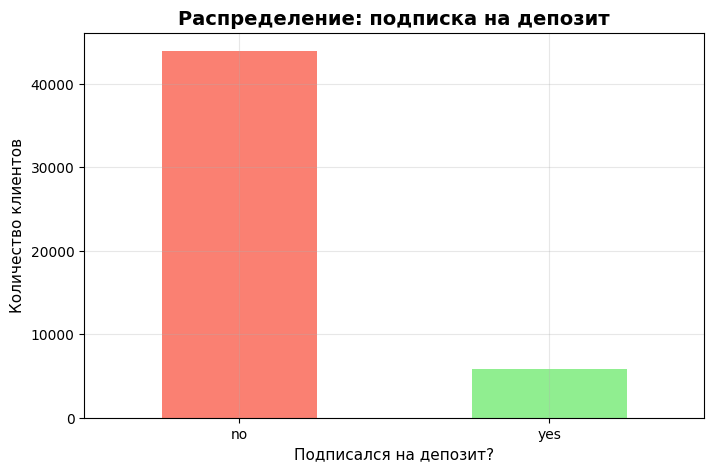

In [6]:
plt.figure(figsize=(8, 5))
df['y'].value_counts().plot(kind='bar', color=['salmon', 'lightgreen'])
plt.title('Распределение: подписка на депозит', fontsize=14, fontweight='bold')
plt.xlabel('Подписался на депозит?', fontsize=11)
plt.ylabel('Количество клиентов', fontsize=11)
plt.xticks(rotation=0)
plt.grid(alpha=0.3)
plt.show()

## 4. Подготовка данных

Нужно закодировать категориальные признаки в числа

In [7]:
df_encoded = df.copy()

df_encoded['y'] = df_encoded['y'].map({'yes': 1, 'no': 0})

categorical_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
print(f"Категориальные признаки ({len(categorical_cols)}): {categorical_cols}\n")

# Кодируем категориальные признаки с помощью LabelEncoder
label_encoders = {}
for column in categorical_cols:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])
    label_encoders[column] = le

print(f"Данные после кодирования: {df_encoded.shape}")
df_encoded.head()

Категориальные признаки (9): ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

Данные после кодирования: (49732, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,4,1,2,0,2143,1,0,2,5,8,261,1,-1,0,3,0
1,44,9,2,1,0,29,1,0,2,5,8,151,1,-1,0,3,0
2,33,2,1,1,0,2,1,1,2,5,8,76,1,-1,0,3,0
3,47,1,1,3,0,1506,1,0,2,5,8,92,1,-1,0,3,0
4,33,11,2,3,0,1,0,0,2,5,8,198,1,-1,0,3,0


In [8]:
print(df_encoded['y'].value_counts())

y
0    43922
1     5810
Name: count, dtype: int64


## 5. Train/Test Split

In [9]:
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Train: {X_train.shape[0]} примеров")
print(f"Test:  {X_test.shape[0]} примеров")
print(f"\nКоличество признаков: {X_train.shape[1]}")

Train: 39785 примеров
Test:  9947 примеров

Количество признаков: 16


## 6. Baseline: Decision Tree (для сравнения)

Сначала обучим одно дерево решений для baseline

In [10]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

y_pred_tree_train = tree.predict(X_train)
y_pred_tree_test = tree.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, y_pred_tree_train)}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_pred_tree_test)}")    
print(f"\nГлубина дерева: {tree.get_depth()}")
print(f"Количество листьев: {tree.get_n_leaves()}")

Train Accuracy: 1.0
Test Accuracy:  0.8918266814114808

Глубина дерева: 31
Количество листьев: 3133


## 7. Random Forest (базовая модель)

In [11]:
rf_basic = RandomForestClassifier(n_estimators=100, random_state=42)
rf_basic.fit(X_train, y_train)

y_pred_rf_train = rf_basic.predict(X_train)
y_pred_rf_test = rf_basic.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, y_pred_rf_train)}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_pred_rf_test)}")

Train Accuracy: 0.9999497297976624
Test Accuracy:  0.9206796018900171


## 8. Влияние количества деревьев (n_estimators)

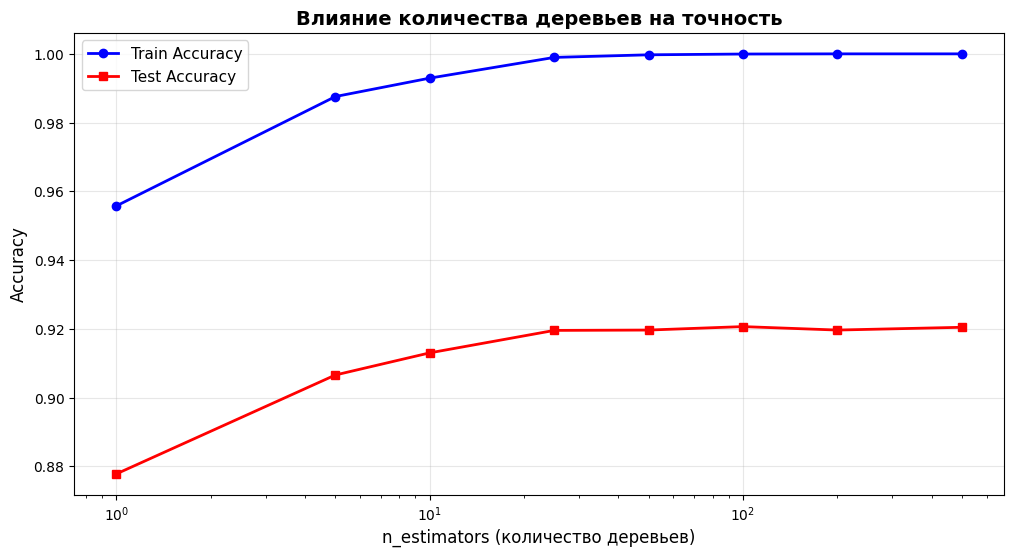

Лучший результат при n_estimators = 100
Test Accuracy: 0.9207


In [12]:
n_trees = [1, 5, 10, 25, 50, 100, 200, 500]
train_scores = []
test_scores = []

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=42)
    rf.fit(X_train, y_train)
    
    train_scores.append(accuracy_score(y_train, rf.predict(X_train)))
    test_scores.append(accuracy_score(y_test, rf.predict(X_test)))

plt.figure(figsize=(12, 6))
plt.plot(n_trees, train_scores, marker='o', label='Train Accuracy', linewidth=2, color='blue')
plt.plot(n_trees, test_scores, marker='s', label='Test Accuracy', linewidth=2, color='red')
plt.xlabel('n_estimators (количество деревьев)', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Влияние количества деревьев на точность', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xscale('log')
plt.show()

print(f"Лучший результат при n_estimators = {n_trees[np.argmax(test_scores)]}")
print(f"Test Accuracy: {max(test_scores):.4f}")

## 9. Out-of-Bag (OOB) Score

In [13]:
rf_oob = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42)
rf_oob.fit(X_train, y_train)

print(f"OOB Score: {rf_oob.oob_score_:.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, rf_oob.predict(X_test)):.4f}")

OOB Score: 0.9172
Test Accuracy: 0.9207


## 10. Feature Importance

In [14]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_basic.feature_importances_
}).sort_values('Importance', ascending=False)

print("Топ-10 самых важных признаков:")
print(feature_importance.head(10))

Топ-10 самых важных признаков:
      Feature  Importance
11   duration    0.292166
5     balance    0.111483
0         age    0.101092
9         day    0.091569
10      month    0.085445
15   poutcome    0.051693
13      pdays    0.050074
1         job    0.049528
12   campaign    0.038548
3   education    0.028139


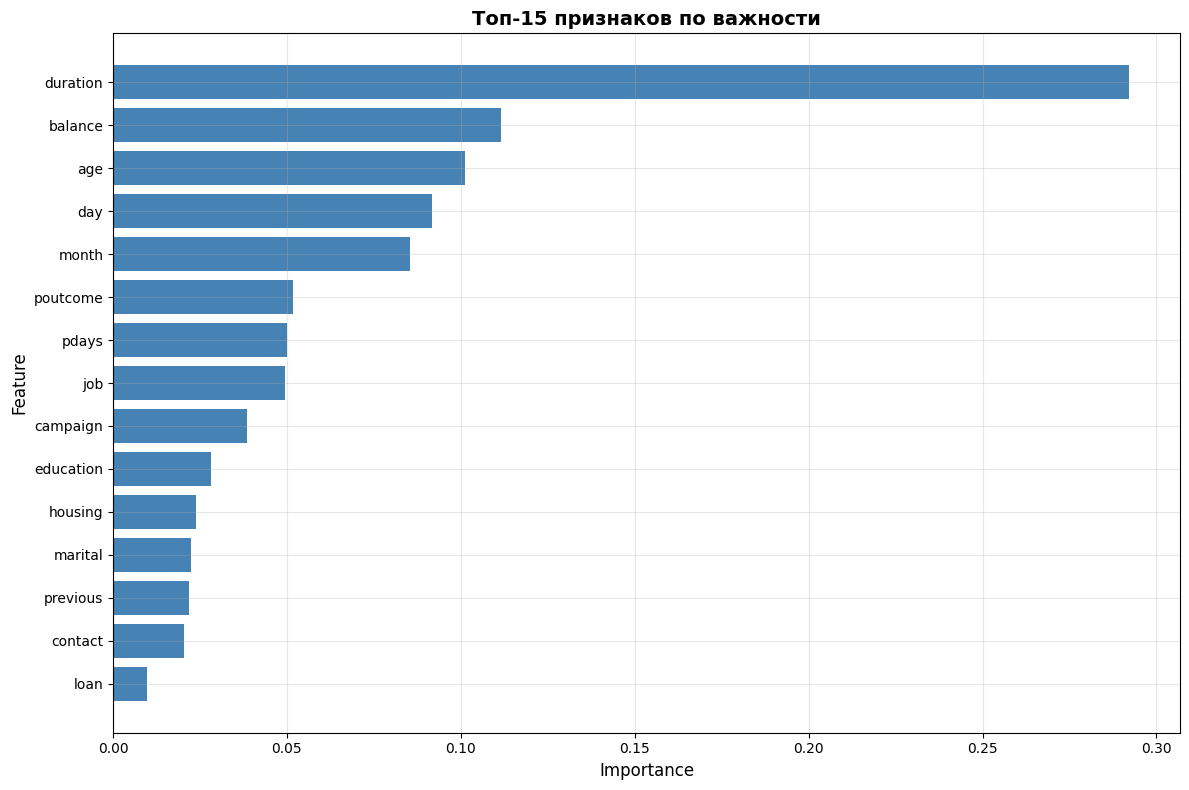

In [15]:
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Топ-15 признаков по важности', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 11. Настройка гиперпараметров

In [16]:
rf_tuned = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1 
)

rf_tuned.fit(X_train, y_train)

y_pred_tuned = rf_tuned.predict(X_test)

print(f"Train Accuracy: {accuracy_score(y_train, rf_tuned.predict(X_train)):.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_pred_tuned):.4f}")

Train Accuracy: 0.9636
Test Accuracy:  0.9150


## 12. Детальная оценка модели

In [17]:
best_rf = rf_tuned  
y_pred_final = best_rf.predict(X_test)

print(f"Accuracy:  {accuracy_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_final):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_final):.4f}")

Accuracy:  0.9150
Precision: 0.7236
Recall:    0.4415
F1-Score:  0.5484


## 13. Confusion Matrix

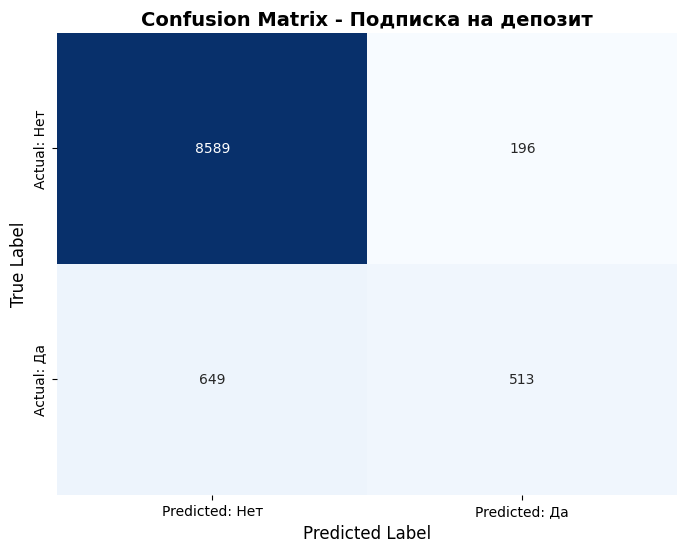


Ошибочно предсказали подписку (False Positive): 196
Упустили потенциальных клиентов (False Negative): 649


In [18]:
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted: Нет', 'Predicted: Да'],
            yticklabels=['Actual: Нет', 'Actual: Да'])
plt.title('Confusion Matrix - Подписка на депозит', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()

print(f"\nОшибочно предсказали подписку (False Positive): {cm[0, 1]}")
print(f"Упустили потенциальных клиентов (False Negative): {cm[1, 0]}")

---

# Задание с другим набором данных

1. Попробовать разные значения `n_estimators` (100, 300, 500) 
2. Настроить параметры `max_depth` и `min_samples_leaf` для улучшения модели
3. Проанализировать топ-5 самых важных признаков
4. Сравнить OOB Score с Test Accuracy - насколько они близки?
